In [143]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

In [144]:
RANDOM_STATE = 42

In [145]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [146]:
# Load data
train_data_full = pd.read_parquet("/home/henrik/projects/cedas2025/src/data/cedas2025_material/data/chargecurves_train.parquet")

In [147]:
len(train_data_full) / 40

99008.725

In [148]:
train_data_full.head()

,id,timestamp,soc,power,nominal_power,location_id,sub_id
0,1,2023-03-15 09:46:44,42.0,37.73,62.5,0,0
1,1,2023-03-15 09:47:44,44.0,30.10,62.5,0,1
2,1,2023-03-15 09:48:44,46.0,27.46,62.5,0,2
3,1,2023-03-15 09:49:44,49.0,26.42,62.5,0,3
4,1,2023-03-15 09:50:44,51.0,25.46,62.5,0,4


In [149]:
train_data_full.loc[train_data_full['id'] == 2]

,id,timestamp,soc,power,nominal_power,location_id,sub_id
40,2,2023-10-13 05:59:50,26.0,0.00,360.0,1,0
41,2,2023-10-13 06:00:50,26.0,66.06,360.0,1,1
42,2,2023-10-13 06:01:50,28.0,66.79,360.0,1,2
43,2,2023-10-13 06:02:50,29.0,67.69,360.0,1,3
44,2,2023-10-13 06:03:50,31.0,68.61,360.0,1,4
45,2,2023-10-13 06:04:50,32.0,70.25,360.0,1,5
46,2,2023-10-13 06:05:50,34.0,71.91,360.0,1,6
47,2,2023-10-13 06:06:50,36.0,73.93,360.0,1,7
48,2,2023-10-13 06:07:50,37.0,75.97,360.0,1,8
49,2,2023-10-13 06:08:50,39.0,76.18,360.0,1,9


In [150]:
def reshape_dataframe(df):
    first_timestamps = df.groupby('id')['timestamp'].first().reset_index()

    pivot_df = df.pivot(index=['id', 'nominal_power', 'location_id'],
                        columns='sub_id',
                        values=['soc', 'power']).reset_index()

    pivot_df.columns = [
        f'{col[0]}_{col[1]}' if col[1] != '' else col[0]
        for col in pivot_df.columns
    ]

    result_df = pivot_df.merge(first_timestamps, on='id')
    return result_df

In [151]:
train_data_full = reshape_dataframe(train_data_full)

In [152]:
train_data_full.head()

,id,nominal_power,location_id,soc_0,soc_1,soc_2,soc_3,soc_4,soc_5,soc_6,soc_7,soc_8,soc_9,soc_10,soc_11,soc_12,soc_13,soc_14,soc_15,soc_16,soc_17,soc_18,soc_19,soc_20,soc_21,soc_22,soc_23,soc_24,soc_25,soc_26,soc_27,soc_28,soc_29,soc_30,soc_31,soc_32,soc_33,soc_34,soc_35,soc_36,soc_37,soc_38,soc_39,power_0,power_1,power_2,power_3,power_4,power_5,power_6,power_7,power_8,power_9,power_10,power_11,power_12,power_13,power_14,power_15,power_16,power_17,power_18,power_19,power_20,power_21,power_22,power_23,power_24,power_25,power_26,power_27,power_28,power_29,power_30,power_31,power_32,power_33,power_34,power_35,power_36,power_37,power_38,power_39,timestamp
0,1,62.5,0,42.0,44.0,46.0,49.0,51.0,53.0,55.0,56.0,58.0,60.0,61.0,62.0,64.0,65.0,66.0,68.0,69.0,70.0,71.0,72.0,73.0,74.0,75.0,76.0,76.0,77.0,78.0,79.0,80.0,81.0,81.0,82.0,83.0,83.0,84.0,84.0,85.0,86.0,86.0,86.0,37.73,30.10,27.46,26.42,25.46,23.55,23.63,22.46,20.93,20.18,18.99,19.06,18.29,17.54,17.21,16.41,16.04,15.67,14.90,14.52,13.76,13.38,13.12,12.39,12.79,12.41,11.64,11.26,10.88,10.11,9.72,9.29,8.94,8.91,8.17,7.79,7.36,7.01,7.02,6.63,2023-03-15 09:46:44
1,2,360.0,1,26.0,26.0,28.0,29.0,31.0,32.0,34.0,36.0,37.0,39.0,41.0,42.0,44.0,46.0,48.0,49.0,51.0,53.0,54.0,56.0,58.0,59.0,61.0,62.0,64.0,65.0,67.0,68.0,69.0,71.0,72.0,73.0,75.0,76.0,77.0,78.0,80.0,81.0,82.0,83.0,0.00,66.06,66.79,67.69,68.61,70.25,71.91,73.93,75.97,76.18,76.01,76.96,72.72,74.03,74.97,74.80,73.88,73.32,72.38,70.31,68.60,67.64,67.06,65.70,64.34,63.74,62.76,61.76,61.15,60.14,58.35,57.72,56.16,54.35,54.10,53.06,52.40,51.35,49.10,47.12,2023-10-13 05:59:50
2,3,62.5,2,60.0,60.0,61.0,62.0,63.0,64.0,65.0,66.0,68.0,68.0,69.0,70.0,71.0,72.0,73.0,74.0,75.0,75.0,76.0,77.0,77.0,78.0,80.0,80.0,80.0,80.0,81.0,82.0,82.0,83.0,83.0,83.0,84.0,84.0,85.0,85.0,86.0,86.0,86.0,87.0,33.95,25.42,24.64,24.67,24.68,24.71,24.73,24.69,23.64,22.47,21.80,21.03,21.02,20.99,20.76,20.39,19.69,19.32,18.81,18.19,17.84,17.45,17.00,17.13,16.33,15.88,15.52,15.26,14.83,14.41,14.44,13.64,13.29,12.63,12.61,11.79,11.46,11.07,11.06,10.67,2024-01-23 04:21:08
3,4,50.0,3,59.0,59.0,60.0,61.0,61.0,62.0,63.0,63.0,64.0,64.0,65.0,65.0,66.0,66.0,67.0,67.0,68.0,68.0,69.0,69.0,70.0,70.0,71.0,71.0,71.0,72.0,72.0,72.0,73.0,73.0,73.0,74.0,74.0,74.0,75.0,75.0,75.0,76.0,76.0,76.0,0.00,17.95,13.43,14.66,13.16,12.82,12.85,11.72,11.37,11.40,11.02,10.67,10.67,10.70,11.08,10.70,10.75,10.31,10.37,10.37,9.60,9.98,8.83,8.83,8.79,9.22,8.81,9.24,9.22,9.22,8.83,9.26,8.88,8.86,8.49,6.91,7.30,7.32,7.30,7.70,2023-12-25 10:45:39
4,5,150.0,4,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,19.0,19.0,19.0,20.0,20.0,21.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,29.0,30.0,31.0,33.0,34.0,35.0,37.0,38.0,39.0,40.0,42.0,0.37,3.38,3.35,3.35,3.72,3.32,3.35,3.35,3.35,3.35,3.35,4.03,6.37,8.79,11.17,13.81,16.64,19.49,22.26,25.36,28.53,32.01,35.60,39.84,47.25,49.16,58.13,70.96,72.46,71.19,70.62,70.01,69.69,68.74,67.49,67.65,66.82,66.21,65.08,64.36,2022-12-12 18:39:31


In [153]:
train_data_full = train_data_full.drop("timestamp",axis=1)
train_data_full = train_data_full.dropna()

In [154]:
unique_values = train_data_full['location_id'].nunique()

print(unique_values)

306


In [155]:
# feature engineer

In [156]:
# average_charging_per_station = 

In [157]:
# lets try to do some clustering
X = StandardScaler().fit_transform(train_data_full)

In [158]:
from sklearn.cluster import KMeans


db = KMeans(random_state=RANDOM_STATE).fit(X)

In [159]:
labels = db.labels_

train_data_full['cluster'] = labels

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 8
Estimated number of noise points: 0


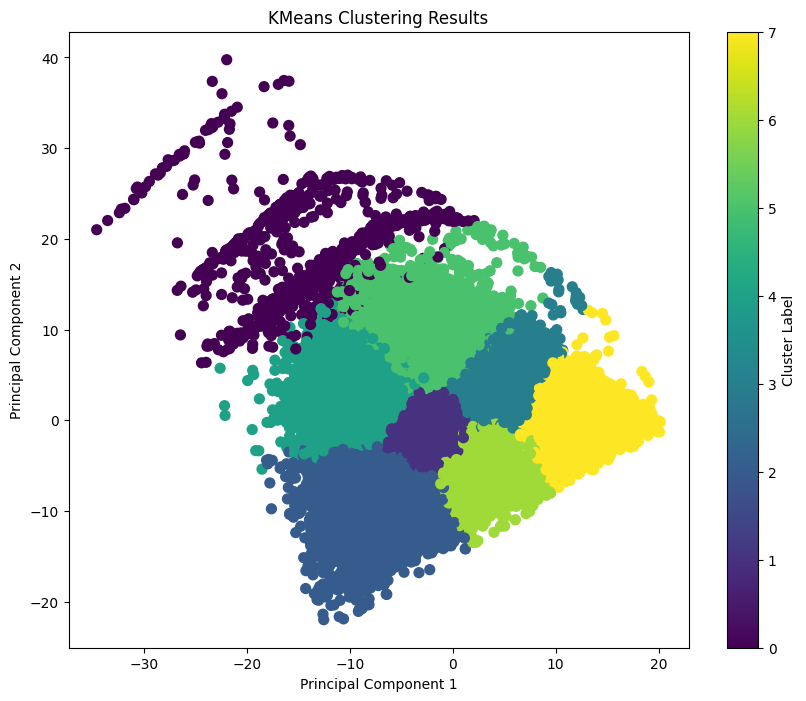

In [ ]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

plt.figure(figsize=(10, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', s=50)
plt.colorbar(label='Cluster Label')
plt.title('KMeans Clustering Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [161]:
train_data_full.head()

,id,nominal_power,location_id,soc_0,soc_1,soc_2,soc_3,soc_4,soc_5,soc_6,soc_7,soc_8,soc_9,soc_10,soc_11,soc_12,soc_13,soc_14,soc_15,soc_16,soc_17,soc_18,soc_19,soc_20,soc_21,soc_22,soc_23,soc_24,soc_25,soc_26,soc_27,soc_28,soc_29,soc_30,soc_31,soc_32,soc_33,soc_34,soc_35,soc_36,soc_37,soc_38,soc_39,power_0,power_1,power_2,power_3,power_4,power_5,power_6,power_7,power_8,power_9,power_10,power_11,power_12,power_13,power_14,power_15,power_16,power_17,power_18,power_19,power_20,power_21,power_22,power_23,power_24,power_25,power_26,power_27,power_28,power_29,power_30,power_31,power_32,power_33,power_34,power_35,power_36,power_37,power_38,power_39,cluster
0,1,62.5,0,42.0,44.0,46.0,49.0,51.0,53.0,55.0,56.0,58.0,60.0,61.0,62.0,64.0,65.0,66.0,68.0,69.0,70.0,71.0,72.0,73.0,74.0,75.0,76.0,76.0,77.0,78.0,79.0,80.0,81.0,81.0,82.0,83.0,83.0,84.0,84.0,85.0,86.0,86.0,86.0,37.73,30.10,27.46,26.42,25.46,23.55,23.63,22.46,20.93,20.18,18.99,19.06,18.29,17.54,17.21,16.41,16.04,15.67,14.90,14.52,13.76,13.38,13.12,12.39,12.79,12.41,11.64,11.26,10.88,10.11,9.72,9.29,8.94,8.91,8.17,7.79,7.36,7.01,7.02,6.63,7
1,2,360.0,1,26.0,26.0,28.0,29.0,31.0,32.0,34.0,36.0,37.0,39.0,41.0,42.0,44.0,46.0,48.0,49.0,51.0,53.0,54.0,56.0,58.0,59.0,61.0,62.0,64.0,65.0,67.0,68.0,69.0,71.0,72.0,73.0,75.0,76.0,77.0,78.0,80.0,81.0,82.0,83.0,0.00,66.06,66.79,67.69,68.61,70.25,71.91,73.93,75.97,76.18,76.01,76.96,72.72,74.03,74.97,74.80,73.88,73.32,72.38,70.31,68.60,67.64,67.06,65.70,64.34,63.74,62.76,61.76,61.15,60.14,58.35,57.72,56.16,54.35,54.10,53.06,52.40,51.35,49.10,47.12,5
2,3,62.5,2,60.0,60.0,61.0,62.0,63.0,64.0,65.0,66.0,68.0,68.0,69.0,70.0,71.0,72.0,73.0,74.0,75.0,75.0,76.0,77.0,77.0,78.0,80.0,80.0,80.0,80.0,81.0,82.0,82.0,83.0,83.0,83.0,84.0,84.0,85.0,85.0,86.0,86.0,86.0,87.0,33.95,25.42,24.64,24.67,24.68,24.71,24.73,24.69,23.64,22.47,21.80,21.03,21.02,20.99,20.76,20.39,19.69,19.32,18.81,18.19,17.84,17.45,17.00,17.13,16.33,15.88,15.52,15.26,14.83,14.41,14.44,13.64,13.29,12.63,12.61,11.79,11.46,11.07,11.06,10.67,7
3,4,50.0,3,59.0,59.0,60.0,61.0,61.0,62.0,63.0,63.0,64.0,64.0,65.0,65.0,66.0,66.0,67.0,67.0,68.0,68.0,69.0,69.0,70.0,70.0,71.0,71.0,71.0,72.0,72.0,72.0,73.0,73.0,73.0,74.0,74.0,74.0,75.0,75.0,75.0,76.0,76.0,76.0,0.00,17.95,13.43,14.66,13.16,12.82,12.85,11.72,11.37,11.40,11.02,10.67,10.67,10.70,11.08,10.70,10.75,10.31,10.37,10.37,9.60,9.98,8.83,8.83,8.79,9.22,8.81,9.24,9.22,9.22,8.83,9.26,8.88,8.86,8.49,6.91,7.30,7.32,7.30,7.70,7
4,5,150.0,4,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,19.0,19.0,19.0,20.0,20.0,21.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,29.0,30.0,31.0,33.0,34.0,35.0,37.0,38.0,39.0,40.0,42.0,0.37,3.38,3.35,3.35,3.72,3.32,3.35,3.35,3.35,3.35,3.35,4.03,6.37,8.79,11.17,13.81,16.64,19.49,22.26,25.36,28.53,32.01,35.60,39.84,47.25,49.16,58.13,70.96,72.46,71.19,70.62,70.01,69.69,68.74,67.49,67.65,66.82,66.21,65.08,64.36,2
